# Imports

In [2]:
from __future__ import annotations  # Needed for typing State class
import ipytest
import weighted_graph_tools as wgt  # See weighted_graph_tools.py in repository
from heapdict import heapdict
from graphviz import Digraph
import random
import pytest
import math

In [3]:
# Set up pytest for Jupyter notebooks
ipytest.autoconfig()

## Vektede grafer 
Du har tidligere jobbet med uvektede grafer, der grafen kun består av noder og kanter,
og alle kanter er like. I en vektet graf er det en vekt/kostnad/distanse assosiert med
hvert kant. Et typisk eksempel er reise: Hver by tilsvarer en node i grafen, og vekten
på kantene mellom nodene tilsvarer for eksempel avstand, reisetid eller billettkostnad.

Du har tidligere brukt en "adjacency list" implementert som en dictionary for å
representere en uventet graf. Vi skal forsette med dette for vektede grafer, men må
gjøre tilpasninger for å inkludere informasjon om vektene til kantene. 

La oss ta utgangspunkt i følgende graf:

![alt text](images/example_weighted_graph.svg)  

Vi representerer denne grafen som en "nøstet" dictionary, altså en dictionary med flere
nivåer. På øverste nivå tilsvarer hver nøkkel en node, og verdien til noden er en
dictionary som beskriver kantene fra noden. Denne "2. nivå dictionary" har nabonodene
som nøkler, og vekten på kantene som verdier. Hvis en node ikke har noen naboer, er 2.
nivå dictionary tom.

### Oppgave 1
Lag en adjacency list som beskriver grafen på bildet over. Koden under er ferdig fylt ut for node A - fyll ut for resten av nodene.

In [4]:
graph = {
    "A": {"B": 2, "C": 5, "E": 9},
    "B": {"C": 1, "D": 4, "E": 5},
    "C": {"D": 2},
    "D": {"A": 1},
    "E": {}
}

### Oppgave 2: Visualiser graf med graphviz
Skriv kode der du bruker graph-variabelen som du nettopp har definert for å lage en
visualisering av grafen. Bruk Digraph-klassen fra graphviz-biblioteket, og bruk "label"
for å indikere vekten på hver kant. OBS: Label må være en string. 

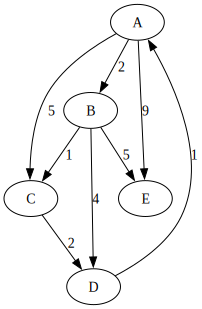

In [5]:
# Use graph (adjacency list) to visualize graph
dot = Digraph(strict=True)
for node in graph:
    dot.node(name=node, label=node)
    for edge_node in graph[node]:
        dot.edge(node, edge_node, label=str(graph[node][edge_node]))
display(dot)


## Dijkstras algoritme

Dijkstras algoritme er en algoritme for å finne korteste eller minst kostbare vei
gjennom en vektet graf. Dijktra's algoritme er veldig lik bredde-først-algoritmen som du
allerede har jobbet med. I bredde-først søk utforskes alle nodene som har en lik avstand
fra startnoden, før man går videre med noder som har større avstand. "Avstand" for
bredde-først søk tilsvarer _antall kanter_ man må gå via for å komme mellom noden og
startnoden. I _vektede_ grafer tilsvarer "avstanden" (eller "kostnaden") summen av
vektene til alle kantene man må gå langs. 

Dijkstras algoritme kan beskrives med følgende pseudokode:
<pre>
    Opprett en dictionary <b>dist</b>
    Opprett en dictionary <b>came_from</b>
    Opprett en prioritetskø <b>queue</b>
    Opprett en liste <b>visited</b>

    Sett avstanden til startnoden i <b>dist</b> til null
    Sett avstanden til alle andre noder i <b>dist</b> til veldig stor / uendelig
    Legg startnoden i <b>queue</b> med prioritet 0
    Sett <b>came_from</b> for startnoden til None

    Så lenge <b>queue</b> ikke er tom:
        Hent neste node fra <b>queue</b> og kall den <b>current</b>
        Legg <b>current</b> til i <b>visited</b>
        For alle <b>neighbor</b> av <b>current</b>:
            Hvis <b>neighbor</b> ikke er besøkt (ikke ligger i <b>visited</b>)
                Beregn kostnad <b>alt_dist</b> for å gå fra startnode til <b>neighbor</b> via <b>current</b>
                Hvis <b>alt_dist</b> er mindre enn det som er registrert i <b>dist</b>:
                    Oppdater <b>dist</b> med den nye (mindre) kostnaden <b>alt_dist</b>
                    Oppdater <b>came_from</b> for <b>neighbor</b> slik at den peker tilbake på <b>current</b>
                    Sett inn/oppdater <b>neighbor</b> i <b>queue</b> med prioritet <b>alt_dist</b>

    Returner <b>dist</b> og <b>came_from</b>
</pre>
<br>
   
I pseudokoden over brukes 4 datastrukturer med ulike funksjoner:
- **dist**: Denne strukturen inneholder en oversikt over _estimert_ distanse/kostnad til
  hver node. Før algoritmen begynner, settes kostnaden til startnoden lik null, og
  kostnaden til alle andre noder lik "uendelig" (eller et tall som er større enn den
  største distansen vi kan forvente, f.eks. 1000000000). Etter hvert som algortimen
  traverserer grafen, kan estimatet oppdateres (hvis man finner mindre kostbare veier
  til nodene).
- **queue**: Dette er prioritetskøen som bestemmer rekkefølgen nodene hentes ut i.
  Prioriteten til hver node settes lik estimert kostnad til noden. Hvis man senere
  oppdaterer kostnaden til en node i dist, må også frontier oppdateres tilsvarende. Bruk
  heapdict som prioritetskø i implementasjonen.
- **came_from**: Denne strukturen angir hvilken node man kommer fra når man går den minst
  kostbare veien. Denne brukes på samme måte som i bredde-først søk.
- **visited**: En liste som inneholder alle besøkte noder. Bruk av denne datastrukturen
  gjør at man unngår mange unødvendige sjekker av nabonoder (man trenger ikke oppdatere
  kostnaden til ferdig besøkte noder). Rekkefølgen i listen viser også hvilken
  rekkefølge nodene ble besøkt i.


### Oppgave 3
Implementer din egen versjon av Dijkstras algoritme i kodecellen under:

In [6]:
# Løsning
def dijkstra(graph: dict, start_node) -> tuple[dict, dict]:
    """Find shortest paths to all nodes using Dijkstra's algorithm

    Parameters
    ----------
    graph: dict
        Dictionary of dictionaries:
        Key (1. level): Name of node.
        Value (1. level): Dictionary with weighted edges from node
        Key (2. level): Name of neighbor
        Value (2. level): Weight of edge to neighbor
        Example: {'A':{'B':5,'C':7}}
        (edge A->B with weight 5, edge A->C with weight 7)
    start_node:
        Name of start node

    Returns
    -------
    dist:
        Dict with key = node and value = shortest distance to node from start.
    came_from:
        Dict containing the preceding node ("came_from") along the shortest path to the
        node from start, for every node. The dict includes the start node,
        came_from[start_node] == None.
    """
    INF = 4611686018427387904
    distance = {}
    came_from = {}
    queue = heapdict()
    visited = []
    for node in graph:
        distance[node] = INF
    distance[start_node] = 0
    queue[start_node] = 0
    came_from[start_node] = None

    while queue.d:
        current = queue.popitem()[0]
        visited.append(current)
        for neighbour in graph[current]:
            if neighbour in visited:
                continue
            alt_dist = distance[current] + graph[current][neighbour]
            if alt_dist >= distance[neighbour]:
                continue
            distance[neighbour] = alt_dist
            came_from[neighbour] = current
            queue[neighbour] = alt_dist
    return distance, came_from

Kjør testene definert i cellen under for å sjekke at din implementasjon fungerer. 

In [7]:
%%ipytest


def test_dijkstra_1():
    """Traverse simple directed graph"""
    directed_graph = {
        "A": {"B": 5, "C": 1},
        "B": {"C": 2, "D": 3},
        "C": {"B": 3, "E": 12},
        "D": {"C": 3, "E": 2, "F": 6},
        "E": {"F": 1},
        "F": {},
    }
    dist, came_from = dijkstra(directed_graph, start_node="A")
    assert dist == {"A": 0, "B": 4, "C": 1, "D": 7, "E": 9, "F": 10}
    assert came_from == {"A": None, "B": "C", "C": "A", "D": "B", "E": "D", "F": "E"}


def test_dijkstra_2():
    """Traverse 3x3 maze with wall in middle
    Forces only two possible paths to a node
    """
    maze_text = wgt.read_maze_text("mazes/maze_3x3_weighted.txt")
    graph = wgt.maze_text_to_graph(maze_text)
    dist, came_from = dijkstra(graph, start_node=(1, 1))
    assert dist == {
        (1, 1): 0,
        (1, 2): 5,
        (1, 3): 12,
        (2, 1): 2,
        (2, 3): 17,
        (3, 1): 3,
        (3, 2): 6,
        (3, 3): 8,
    }
    assert came_from == {
        (1, 1): None,
        (2, 1): (1, 1),
        (1, 2): (1, 1),
        (3, 1): (2, 1),
        (3, 2): (3, 1),
        (1, 3): (1, 2),
        (3, 3): (3, 2),
        (2, 3): (3, 3),
    }


def test_traverse_3():
    """Traverse 5x5 weighted maze with some walls in the middle
    More complex maze with more "open space" than the 3x3 maze tested above
    """
    maze_text = wgt.read_maze_text("mazes/maze_5x5_weighted.txt")
    graph = wgt.maze_text_to_graph(maze_text)
    dist, _ = dijkstra(graph, start_node=(1, 1))
    assert dist[(4, 1)] == 14
    assert dist[(4, 2)] == 11
    assert dist[(3, 5)] == 20
    assert dist[(4, 5)] == 24


...                                                                                          [100%]
3 passed in 0.02s


## Grådig søk
Grådig søk er en algoritme for søk i grafer som sorterer rekkefølgen nodene besøkes i
basert på om man beveger seg nærmere en sluttnode eller ikke. Algoritmen er nærmere
beskrevet i videoer relatert til modulen om vektede grafer. 

I vårt konkrete tilfelle med rutenett bruker vi den såkalte
[Manhattan-distansen](https://en.wikipedia.org/wiki/Taxicab_geometry) (også kalt
L1-distansen eller "taxicab"-distansen) for å beregne avstanden til sluttnoden.


## Oppgave 4
Implementer en funksjon som beregner Manhattan-distansen mellom to punkter.

In [8]:
# Løsning
def manhattan_distance(p1: tuple[float, float], p2: tuple[float, float]) -> float:
    """Calculate Manhattan distance between two points

    Parameters
    ----------
    p1 : tuple[float,float]
        First point, with two coordinates
    p2 : tuple[float,float]
        Second point, with two coordinates

    Returns
    -------
    m_dist : float
        Manhattan distance between p1 and p2
    """
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])


Test koden din ved å kjøre testene i cellen under:

In [9]:
%%ipytest


def test_manhattan_distance_1():
    p1 = (0, 0)
    p2 = (3, 2)
    assert manhattan_distance(p1, p2) == 5


def test_manhattan_distance_2():
    p1 = (3, 2)
    p2 = (3, 2)
    assert manhattan_distance(p1, p2) == 0


def test_manhattan_distance_3():
    p1 = (1, -5)
    p2 = (-3, 7)
    assert manhattan_distance(p1, p2) == 16


def test_manhattan_distance_4():
    p1 = (1.0, 2.0)
    p2 = (1.5, 1.1)
    assert manhattan_distance(p1, p2) == 1.4

....                                                                                         [100%]
4 passed in 0.02s


### Grådig søk - pseudokode
<pre>
    Opprett en dictionary <b>came_from</b>
    Opprett en prioritetskø <b>queue</b>
    Opprett en liste <b>visited</b>

    Legg startnoden i <b>queue</b> med prioritet 0
    Sett <b>came_from</b> for startnoden til None

    Så lenge <b>queue</b> ikke er tom:
        Hent neste node fra <b>queue</b> og kall den <b>current</b>
        Legg <b>current</b> til i <b>visited</b>

        Hvis <b>current</b> tilsvarer sluttnoden:
            Stopp søk (hopp ut av løkke)

        For alle <b>neighbor</b> av <b>current</b>:
            Hvis <b>neighbor</b> ikke ligger i <b>visited</b> eller i <b>queue</b>:
                Sett <b>came_from</b> for <b>neighbor</b> til <b>current</b>
                Beregn Manhattan-distansen <b>m_dist</b> mellom <b>neighbor</b> og sluttnoden
                Sett inn/oppdater <b>neighbor</b> i <b>queue</b> med prioritet <b>m_dist</b> 

    Bruk <b>came_from</b> for å rekonstruere veien fra startnoden til sluttnode,
    og beskriv veien som en liste <b>path</b> med alle nodene fra start til slutt.
    Beregn total distanse langs <b>path</b> og lagre den som <b>path_dist</b>

    Returner <b>path_dist</b>, <b>path</b>, <b>came_from</b>, og <b>visited</b>
</pre>
<br>

### Oppgave 5
Implementer din egen versjon av grådig søk i cellen under:

In [10]:
def greedy_search(
    graph: dict, start_node: tuple[int, int], end_node: tuple[int, int]
) -> tuple[float, list, dict, list]:
    """Find path from start to end node in graph using greedy search

    Arguments
    ---------
    graph: dict
        Dictionary of dictionaries:
        Key (1. level): Name of node.
        Value (1. level): Dictionary with weighted edges from node
        Key (2. level): Name of neighbor
        Value (2. level): Weight of edge to neighbor
        Example: {'A':{'B':5,'C':7}}
        (edge A->B with weight 5, edge A->C with weight 7)
    start_node: tuple[int, int]
        Coordinates of start node
    end_node:  tuple[int, int]
        Coordinates of end node

    Returns
    -------
    path_dist: float
        Distance from start node to end node in graph
        (not necessarily the shortest distance)
    path:
        List containing every node along path followed
        from start to end node (including both).
    came_from: dist
        Dict containing the preceding node ("came_from") along the
        shortest path to the node from start, for every node.
        The dict includes the start node, came_from[start_node] == None.
    visited:
        List containing nodes visited during search, ordered from first
        (start_node) to last (end_node).

    """
    came_from = {}
    queue = heapdict()
    visited = []

    queue[start_node] = 0
    came_from[start_node] = None

    while queue.d:
        current = queue.popitem()[0]
        visited.append(current)
        if current == end_node:
            break
        for neighbour in graph[current]:
            if neighbour in visited or neighbour in queue:
                continue
            came_from[neighbour] = current
            m_dist = manhattan_distance(neighbour, end_node)
            queue[neighbour] = m_dist

    path = [end_node]
    while path[-1] is not None:
        path.append(came_from[path[-1]])
    path = path[::-1][1:]

    path_dist = 0
    for i in range(len(path) - 1):
        path_dist += graph[path[i]][path[i+1]]
        
    return path_dist, path, came_from, visited

Kjør testene i cellen under for å vise at koden din fungerer.

In [11]:
%%ipytest


def test_greedy_search_1():
    """Test greedy search in open maze with all edge weights equal"""
    maze_text = wgt.read_maze_text("mazes/maze_10x10_uniform_cost.txt")
    graph = wgt.maze_text_to_graph(maze_text)
    start_node = (5, 5)
    end_node = (8, 8)
    path_dist, path, came_from, visited = greedy_search(
        graph, start_node=start_node, end_node=end_node
    )
    assert path_dist == 6
    assert len(visited) == 7
    assert len(path) == 7
    assert path[0] == (5, 5)
    assert path[-1] == (8, 8)


def test_greedy_search_2():
    """Test greedy search in maze with high-cost corner wall"""
    maze_text = wgt.read_maze_text("mazes/maze_10x10_corner.txt")
    graph = wgt.maze_text_to_graph(maze_text)
    path_dist, path, came_from, visited = greedy_search(
        graph, start_node=(5, 5), end_node=(10, 10)
    )
    assert path_dist == 18  # Distance when going straight through high-cost wall
    assert len(visited) == 11
    assert len(path) == 11
    assert path[0] == (5, 5)
    assert path[-1] == (10, 10)

..                                                                                           [100%]
2 passed in 0.01s


## A\* 
A\* er en søkealgoritme som kombinerer elementer fra både Dijkstras algoritme og grådig
søk. Algoritmen prioriterer å utforske ikke-besøkte noder der summen av avstanden fra
startnoden og den estimerte avstanden til sluttnoden er lav. Gjennom å gjøre dette,
trenger ikke algoritmen å besøke like mange noder som Dijkstra før den finner korteste
vei til sluttnoden. Det gjør algoritmen mer effektiv. 

En mer inngående beskrivelse av A\*, med sammenligninger med Dijkstra's algoritme og
grådig søk, er gitt i videoer som hører til modulen om vektede grafer. 

Grådig søk og A\* bruker et estimat av avstanden/kostnaden fra en node til sluttnoden.
Dette kalles en "heuristikk". I vårt konkrete tilfelle med rutenett lar vi heuristikken
være Manhattan-distansen mellom nodene. 

A\* kan beskrives med følgende pseudokode:

<pre>
    Opprett en dictionary <b>dist</b>
    Opprett en dictionary <b>came_from</b>
    Opprett en prioritetskø <b>queue</b>
    Opprett en liste <b>visited</b>

    Sett avstanden til startnoden i <b>dist</b> til null
    Sett avstanden til alle andre noder i <b>dist</b> til veldig stor / uendelig
    Legg startnoden i <b>queue</b> med prioritet 0
    Sett <b>came_from</b> for startnoden til None

    Så lenge <b>queue</b> ikke er tom:
        Hent neste node fra <b>queue</b> og kall den <b>current</b>
        Legg <b>current</b> til i <b>visited</b>

        Hvis <b>current</b> tilsvarer sluttnoden:
            Stopp søk (hopp ut av løkke)

        For alle <b>neighbor</b> av <b>current</b>:
            Hvis <b>neighbor</b> ikke er besøkt (ikke ligger i <b>visited</b>)
                Beregn kostnad <b>alt_dist</b> for å gå fra startnode til <b>neighbor</b> via <b>current</b>
                Hvis <b>alt_dist</b> er mindre enn det som er registrert i <b>dist</b>:
                    Oppdater <b>dist</b> med den nye (mindre) kostnaden <b>alt_dist</b>
                    Oppdater <b>came_from</b> for <b>neighbor</b> slik at den peker tilbake på <b>current</b>
                    Beregn Manhattan-distansen <b>m_dist</b> mellom <b>neighbor</b> og sluttnoden
                    Sett <b>priority</b> lik summen av <b>alt_dist</b> og <b>m_dist</b>
                    Sett inn/oppdater <b>neighbor</b> i <b>queue</b> med prioritet <b>priority</b>

    Bruk <b>came_from</b> for å rekonstruere veien fra startnoden til sluttnode,
    og beskriv veien som en liste <b>path</b> med alle nodene fra start til slutt.
    La <b>path_dist</b> tilsvare distansen til sluttnoden registrert i <b>dist</b>

    Returner <b>path_dist</b>, <b>path</b>, <b>came_from</b>, og <b>visited</b>
</pre>
<br>

### Oppgave 6
Implementer din egen versjon av A* i kodecellen under:

In [12]:
def astar(
    graph: dict, start_node: tuple[int, int], end_node: tuple[int, int]
) -> tuple[float, list, dict, list]:
    """Find shortest path from start to end node in graph using A*

    Arguments
    ---------
    graph: dict
        Dictionary of dictionaries:
        Key (1. level): Name of node.
        Value (1. level): Dictionary with weighted edges from node
        Key (2. level): Name of neighbor
        Value (2. level): Weight of edge to neighbor
    start_node: tuple[int, int]
        Coordinates of start node
    end_node:  tuple[int, int]
        Coordinates of end node

    Returns
    -------
    path_dist: float
        Distance from start node to end node in graph
        (not necessarily the shortest distance)
    path:
        List containing every node along path followed
        from start to end node (including both).
    came_from: dist
        Dict containing the preceding node ("came_from") along the
        shortest path to the node from start, for every node.
        The dict includes the start node, came_from[start_node] == None.
    visited:
        List containing nodes visited during search, ordered from first
        (start_node) to last (end_node).
    """

    INF = 4611686018427387904
    distance = {}
    came_from = {}
    queue = heapdict()
    visited = []
    for node in graph:
        distance[node] = INF
    distance[start_node] = 0
    queue[start_node] = 0
    came_from[start_node] = None

    while queue.d:
        current = queue.popitem()[0]
        visited.append(current)

        if current == end_node:
            break

        for neighbour in graph[current]:
            if neighbour in visited:
                continue
            alt_dist = distance[current] + graph[current][neighbour]
            if alt_dist >= distance[neighbour]:
                continue
            distance[neighbour] = alt_dist
            came_from[neighbour] = current
            m_dist = manhattan_distance(neighbour, end_node)
            queue[neighbour] = alt_dist + m_dist
    
    path = [end_node]
    while path[-1] is not None:
        path.append(came_from[path[-1]])
    path = path[::-1][1:]

    path_dist = 0
    for i in range(len(path) - 1):
        path_dist += graph[path[i]][path[i+1]]
        
    return path_dist, path, came_from, visited

Sjekk at koden fungerer ved å kjøre testkoden under:

In [13]:
%%ipytest


def test_astar_1():
    """Test A* in simple 3x3 maze with center wall"""
    maze_text = wgt.read_maze_text("mazes/maze_3x3_weighted.txt")
    graph = wgt.maze_text_to_graph(maze_text)
    dist, path, came_from, visited = astar(graph, start_node=(1, 1), end_node=(2, 3))
    assert dist == 17
    assert came_from == {
        (1, 1): None,
        (2, 1): (1, 1),
        (1, 2): (1, 1),
        (3, 1): (2, 1),
        (3, 2): (3, 1),
        (1, 3): (1, 2),
        (3, 3): (3, 2),
        (2, 3): (3, 3),
    }
    assert path == [(1, 1), (2, 1), (3, 1), (3, 2), (3, 3), (2, 3)]
    assert visited == [(1, 1), (2, 1), (3, 1), (1, 2), (3, 2), (3, 3), (1, 3), (2, 3)]


def test_astar_2():
    """Test A* in maze with high-cost corner wall"""
    maze_text = wgt.read_maze_text("mazes/maze_10x10_corner.txt")
    graph = wgt.maze_text_to_graph(maze_text)
    dist, path, came_from, visited = astar(graph, start_node=(5, 5), end_node=(10, 10))
    assert dist == 12
    assert len(came_from) == 44
    assert len(visited) == 25
    assert len(path) == 13
    assert path[0] == (5, 5)
    assert path[-1] == (10, 10)


def test_astar_3():
    """Test A* in 10x10 maze with many different weights"""
    maze_text = wgt.read_maze_text("mazes/maze_10x10_weighted.txt")
    graph = wgt.maze_text_to_graph(maze_text)
    dist, _, _, _ = astar(graph, start_node=(1, 1), end_node=(7, 1))
    assert dist == 28
    dist, _, _, _ = astar(graph, start_node=(1, 1), end_node=(5, 8))
    assert dist == 21
    dist, _, _, _ = astar(graph, start_node=(1, 1), end_node=(10, 10))
    assert dist == 43

...                                                                                          [100%]
3 passed in 0.03s


## Markov-kjeder
En Markov-kjede eller Markov-prosess er en stokatisk prosess som beskriver overganger
mellom ulike tilstander. Prosessen beskrives som en graf der hver node tilsvarer en
tilstand, og hver kant tilsvarer overgangen til en annen tilstand. Vekten for kanten
tilsvarer sannsynligheten for overgangen.  

Her er et eksempel som viser ulike temperaturtilstander og overganger mellom disse:

![alt text](images/markov_state.png)

I eksempelet over er sannsynligheten for å gå fra "Cold" til "Normal" lik 0.8, eller
80%.

Markov-kjeder er beskrevet i mer detalj i videoer som hører til denne modulen.

### Oppgave 7
Implementer en klasse "State" som representerer en tilstand, og sannsynligheten for å gå
fra nåværende tilstand til en annen tilstand. Legg merke til at du må gjøre et tilfeldig
valg basert på sannsynligheter - bruk gjerne random-modulen for å gjøre dette. 

In [31]:
class State:
    """
    Class representing a state in a Markov chain. Each state has a set of neighbors in
    the form of a dictionary. Keys point to the neighboring state(s) and values
    represent transition probability
    """

    def __init__(self, name):
        self.name = name
        self._neighbors = {}

    def add_neighbor(self, neighbor: State, probability: float):
        """Adds a new neighbor to the state

        Parameters
        ----------
        neighbor: State
            A pointer to a neighboring instance of State
        probability: float
            The probability of going to the neighbor
        """
        self._neighbors[neighbor] = probability

    def get_next_state(self) -> State:
        """Returns a new state based on neigbor probability

        Returns
        -------
        next_state: State
            A new random state based on probability
        """
        neighbours = tuple(self._neighbors.keys())
        probabilities = (self._neighbors[neighbour] for neighbour in neighbours)
        return random.choices(neighbours, weights=probabilities)[0]

Test koden din ved å kjøre cellene under:

In [32]:
%%ipytest


def test_state_transition():
    """Simple state transition test"""

    state_1 = State("A")
    state_2 = State("B")

    state_1.add_neighbor(state_2, 1.0)
    state_2.add_neighbor(state_1, 1.0)

    # should go from state 1 -> state 2
    next_state = state_1.get_next_state()

    assert next_state == state_2


def test_two_state_transition():
    """Simple two-state transition test"""

    state_1 = State("A")
    state_2 = State("B")

    state_1.add_neighbor(state_2, 1.0)
    state_2.add_neighbor(state_1, 1.0)

    # should go from state 1 -> state 2 -> state 1
    next_state = state_1.get_next_state()
    next_state = next_state.get_next_state()

    assert next_state == state_1


def test_multiple_transitions():
    """Multiple state transitions test"""

    state_1 = State("A")
    state_2 = State("B")
    state_3 = State("C")
    state_4 = State("D")
    state_5 = State("E")

    state_1.add_neighbor(state_2, 1.0)
    state_2.add_neighbor(state_3, 1.0)
    state_3.add_neighbor(state_4, 1.0)
    state_4.add_neighbor(state_5, 1.0)

    # should go from state 1 -> ... -> state 5
    current_state = state_1
    for _ in range(4):
        next_state = current_state.get_next_state()
        current_state = next_state

    assert current_state == state_5

...                                                                                          [100%]
3 passed in 0.02s


## Oppgave 8
Lag en funksjon som simulerer hvordan temperaturen utvikler seg, basert på Markovkjeden
med temperaturer, og State-klassen som du har implementert. Du vil være nødt til å bygge
en kjede med 4 States, tilsvarende de ulike temperaturtilstandene ("Cold", "Normal",
"Hot", "Overheating"). 

Funksjonen skal returnere sannsynlighetene for å ende opp i hvert tilstand. For å
beregne dette må du kjøre flere simuleringer og logge hvilken tilstand man endte opp i i
hvert tilfelle. Hver simulering skal inneholde det samme antall overganger mellom tilstander.
**Starttilstanden er alltid "Cold"**.

![alt text](images/markov_state.png)

In [35]:
def simulate_temperature(n_simulations: int, n_transitions: int) -> dict[str, float]:
    """Monte Carlo simulation of temperature state ("Cold", "Normal", "Hot", "Overheating")

    Assignment: Create State objects according to the graph given in
    the file markov_state.png. Run Monte Carlo simulations on the
    according to the input arguments. The initial state is always "Cold".

    Parameters
    ----------
    n_simulations: int
        Number of Monte Carlo simulations to run
    n_transitions: INT
        Number of state transitions

    Returns
    -------
    prob: dict[str, float]
        A dictionary listing probabilities as percentages
        keys:    State names ("Cold", "Normal", "Hot", "Overheating")
        values:  Probabilities in %

    Notes
    -----
    The probabilities will change each time the function is run.
    However, with a large number of simulations, the probabilities should be
    relatively stable.
    """
    cold = State("Cold")
    normal = State("Normal")
    hot = State("Hot")
    overheating = State("Overheating")

    cold.add_neighbor(cold, 0.2)
    cold.add_neighbor(normal, 0.8)
    normal.add_neighbor(cold, 0.3)
    normal.add_neighbor(normal, 0.6)
    normal.add_neighbor(hot, 0.1)
    hot.add_neighbor(normal, 0.5)
    hot.add_neighbor(overheating, 0.5)
    overheating.add_neighbor(overheating, 1.0)

    counter = {"Cold" : 0, "Normal": 0, "Hot": 0, "Overheating": 0}
    for _ in range(n_simulations):
        current_state = cold
        for _ in range(n_transitions):
            current_state = current_state.get_next_state()
        counter[current_state.name] += 1
    probabilities = {state : counter[state] * 100 / n_simulations for state in counter}
    return probabilities


Sjekk at koden virker ved å kjøre testene i cellen under:

In [36]:
%%ipytest


def test_simulate_temperature():
    """Run simulation and check that probabilities are within reasonable range"""
    prob = simulate_temperature(1000, 10)
    assert prob["Cold"] == pytest.approx(20.0, abs=7.0)
    assert prob["Normal"] == pytest.approx(50.0, abs=10.0)
    assert prob["Hot"] == pytest.approx(5.0, abs=5.0)
    assert prob["Overheating"] == pytest.approx(25.0, abs=10.0)


def test_simulate_temperature_final_state():
    """Run simulation for many transitions - converges towards overheating"""
    prob = simulate_temperature(1000, 200)
    assert prob["Overheating"] > 99.0

..                                                                                           [100%]
2 passed in 0.53s
